### Load Libraries

In [1]:
library(vegan)
library(phyloseq)
library(ranacapa)
library(ggplot2)
library(ggpubr)
library(stringr)
library(reshape2)
library(ggh4x)
library(ggpattern)

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4



### Create directories

In [2]:
dir.create(file.path('../../results/figures'), showWarnings = FALSE)
dir.create(file.path('../../results/figures', 'figure1'), showWarnings = FALSE)

### Load data

In [3]:
ps <- readRDS('../../data/phyloseq/nohost_asv/phyloseq.rds')
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 17022 taxa and 199 samples ]
sample_data() Sample Data:       [ 199 samples by 57 sample variables ]
tax_table()   Taxonomy Table:    [ 17022 taxa by 7 taxonomic ranks ]

# Figures

## 1B Demographics

#### Prepare a table

In [4]:
# load data
metadata <- data.frame(sample_data(ps))
metadata[is.na(metadata$Maternaleducationalstatus), ]$Maternaleducationalstatus <- 99 # fill NAs
# split a data table in two: baseline and follow-up samples
metadata_baseline <- metadata[metadata$collection_timepoint == 'baseline', ]
metadata_followup <- metadata[metadata$collection_timepoint == 'follow-up', ]

In [5]:
# select columns and values of interest
columns = c('host_sex', 'host_age', 'Householdno', 'Wheredoyoulive', 'Maternaleducationalstatus')
labels = list(host_sex=c('Female', 'Male'),
              host_age=c('5-8', '9-12', '12+'),
              Householdno=c('0-3', '4-7', '7+'), 
              Wheredoyoulive=c('Urban', 'Suburban', 'Rural'), 
              Maternaleducationalstatus=c('Illiterate', 'Primary school', 
                                          'Highschool', 'Higher education',  'Unknown'))

breaks = list(host_age=c(-Inf, 8, 12, Inf),
              Householdno=c(-Inf, 3, 7, Inf))

group_names = list(host_sex='Sex',
                   host_age='Age',
                   Householdno='Household size', 
                   Wheredoyoulive='Residence', 
                   Maternaleducationalstatus='Maternal Education')

In [6]:
# baseline samples
# transform continues values into groups and categories into factors
metadata_stratified_baseline <- lapply(columns, function(x){
    if (x %in% names(breaks)){
        tmp <- data.frame(table(cut(metadata_baseline[[x]], 
                     breaks = breaks[[x]], labels = labels[[x]])))
    } else {
        tmp <- data.frame(table(metadata_baseline[[x]]))
        tmp$Var1 <- labels[[x]]
    }
    tmp$Var1 <- factor(tmp$Var1, levels=rev(labels[[x]]))
    tmp$type <- factor(group_names[[x]], levels=group_names[[x]])
    return(tmp)
})

# save a copy of a vector for statistical testing
metadata_stratified_baseline_test <- metadata_stratified_baseline 
# transform to a dataframe
metadata_stratified_baseline <- do.call('rbind', metadata_stratified_baseline)
metadata_stratified_baseline$Freq <- metadata_stratified_baseline$Freq/dim(metadata_baseline)[1]
metadata_stratified_baseline$timepoint <- 'baseline'
metadata_stratified_baseline$text <- lapply(metadata_stratified_baseline$Freq, function(x){
                                          scales::percent(abs(x), accuracy = 1)})

In [7]:
# follow-up samples
# transform continues values into groups and categories into factors
metadata_stratified_followup <- lapply(columns, function(x){
    if (x %in% names(breaks)){
        tmp <- data.frame(table(cut(metadata_followup[[x]], 
                     breaks = breaks[[x]], labels = labels[[x]])))
    } else {
        tmp <- data.frame(table(metadata_followup[[x]]))
        tmp$Var1 <- labels[[x]]
    }
    tmp$Var1 <- factor(tmp$Var1, levels=rev(labels[[x]]))
    tmp$type <- factor(group_names[[x]], levels=group_names[[x]])
    return(tmp)
})

# save a copy of a vector for statistical testing
metadata_stratified_followup_test <- metadata_stratified_followup
# transform to a dataframe
metadata_stratified_followup <- do.call('rbind', metadata_stratified_followup)
metadata_stratified_followup$Freq <- metadata_stratified_followup$Freq/dim(metadata_followup)[1]
metadata_stratified_followup$text <- lapply(metadata_stratified_followup$Freq, function(x){
                                          scales::percent(abs(x), accuracy = 1)})
metadata_stratified_followup$timepoint <- 'follow-up'

In [8]:
# combine baseline and follow-up samples metadata
metadata_stratified <- rbind(metadata_stratified_baseline, metadata_stratified_followup)
metadata_stratified$timepoint <- factor(metadata_stratified$timepoint, levels=c('follow-up', 'baseline'))

#### Statistical testing

In [9]:
# compute chi-squared test and retrieve p-values
names(metadata_stratified_baseline_test) <- columns
names(metadata_stratified_followup_test) <- columns

chi2_pval <- lapply(columns, function(x){
    chi = chisq.test(x=metadata_stratified_followup_test[[x]]$Freq, 
                     p=metadata_stratified_baseline_test[[x]]$Freq/dim(metadata_baseline)[1])
    return(chi$p.value)
})
names(chi2_pval) <- columns

Warning message in chisq.test(x = metadata_stratified_followup_test[[x]]$Freq, p = metadata_stratified_baseline_test[[x]]$Freq/dim(metadata_baseline)[1]):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(x = metadata_stratified_followup_test[[x]]$Freq, p = metadata_stratified_baseline_test[[x]]$Freq/dim(metadata_baseline)[1]):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(x = metadata_stratified_followup_test[[x]]$Freq, p = metadata_stratified_baseline_test[[x]]$Freq/dim(metadata_baseline)[1]):
“Chi-squared approximation may be incorrect”


In [10]:
# compute chi-squared test and retrieve test statistic
names(metadata_stratified_baseline_test) <- columns
names(metadata_stratified_followup_test) <- columns

chi2_stat <- lapply(columns, function(x){
    chi = chisq.test(x=metadata_stratified_followup_test[[x]]$Freq, 
                     p=metadata_stratified_baseline_test[[x]]$Freq/dim(metadata_baseline)[1])
    return(chi$statistic)
})
names(chi2_stat) <- columns

Warning message in chisq.test(x = metadata_stratified_followup_test[[x]]$Freq, p = metadata_stratified_baseline_test[[x]]$Freq/dim(metadata_baseline)[1]):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(x = metadata_stratified_followup_test[[x]]$Freq, p = metadata_stratified_baseline_test[[x]]$Freq/dim(metadata_baseline)[1]):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(x = metadata_stratified_followup_test[[x]]$Freq, p = metadata_stratified_baseline_test[[x]]$Freq/dim(metadata_baseline)[1]):
“Chi-squared approximation may be incorrect”


In [11]:
# reformat tables
# transform factors to characters
metadata_stratified_followup$type_char <- as.character(metadata_stratified_followup$type)
metadata_stratified_baseline$type_char <- as.character(metadata_stratified_baseline$type)
metadata_stratified$type_char <- as.character(metadata_stratified$type)

# round p-values and test statistic
chi2_pval <- format(as.vector(unlist(chi2_pval)), digits=2)
chi2_stat <- format(as.vector(unlist(chi2_stat)), digits=2)

# add chi-squared test p-values to baseline, follow-up and combined metadata tables
metadata_stratified_baseline$pval <- format(as.vector(unlist(chi2_pval[metadata_stratified_baseline$type])), digits=2)
metadata_stratified_followup$pval <- format(as.vector(unlist(chi2_pval[metadata_stratified_followup$type])), digits=2)
metadata_stratified$pval <- format(as.vector(unlist(chi2_pval[metadata_stratified$type])), digits=2)

# add chi-squared test p-values to baseline, follow-up and combined metadata tables
metadata_stratified_baseline$stat <- format(as.vector(unlist(chi2_stat[metadata_stratified_baseline$type])), digits=2)
metadata_stratified_followup$stat <- format(as.vector(unlist(chi2_stat[metadata_stratified_followup$type])), digits=2)
metadata_stratified$stat <- format(as.vector(unlist(chi2_stat[metadata_stratified$type])), digits=2)

#### Plot a figure

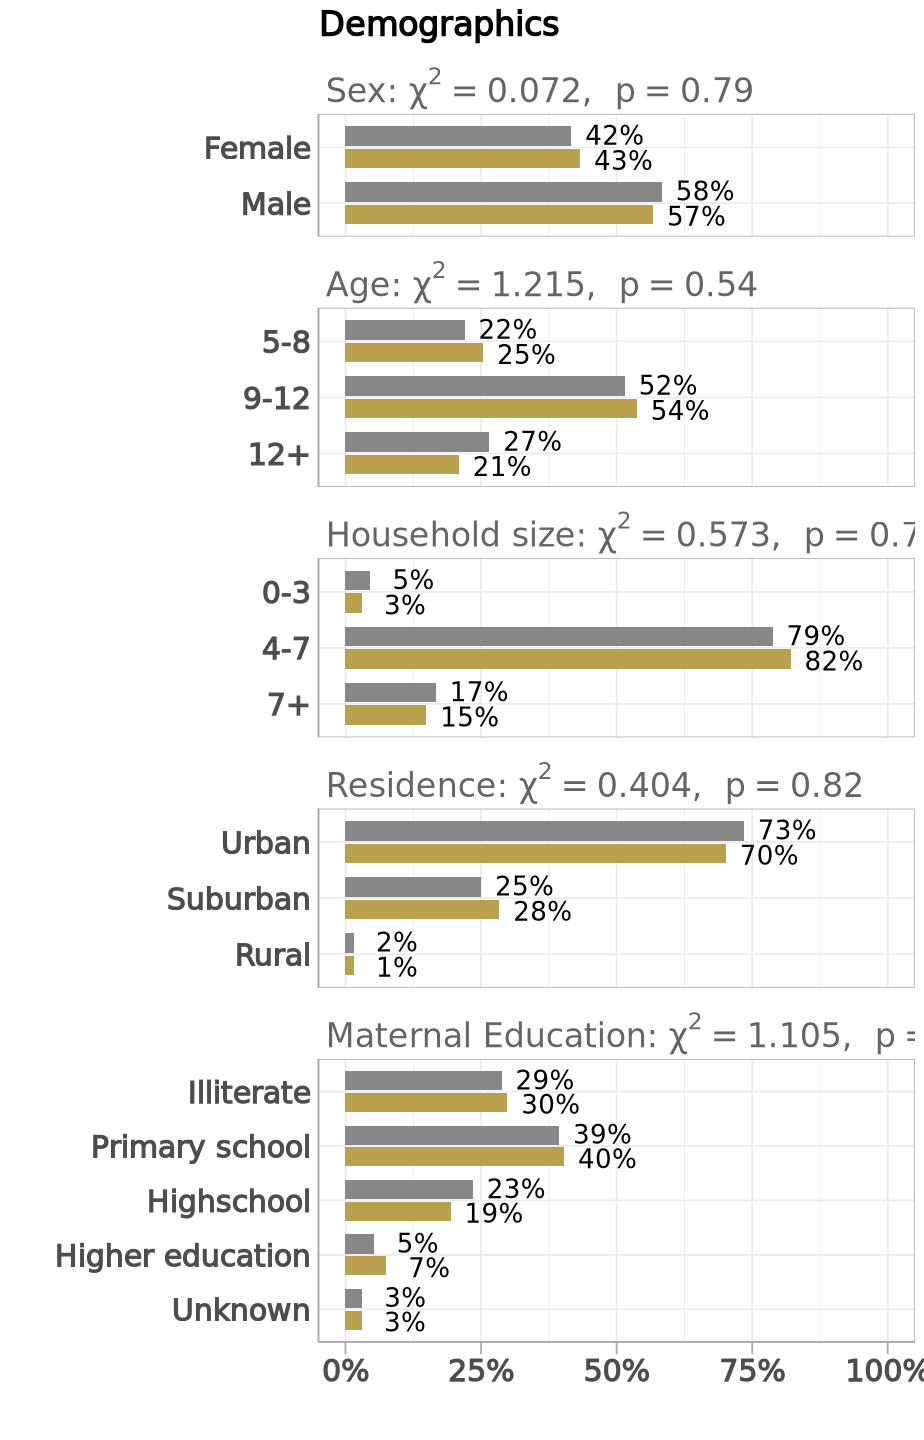

In [12]:
# set a figure size
width = 7.7
height = 12
options(repr.plot.width=width, repr.plot.height=height)

# plot a figure
p_discrete <- ggplot(data = metadata_stratified, 
                     aes(x=Var1, 
                         y=Freq, 
                         fill=timepoint,
                         group=timepoint)) +
  geom_bar(stat="identity",
                width = .7, position = position_dodge(width = 0.8)) +
  geom_text(aes(label=text, y=Freq+0.08), position = position_dodge(width = 0.9), size=5.5) +
  coord_flip() +
  facet_wrap(~type+type_char+stat+pval, ncol=1, scale='free_y', 
             labeller = label_bquote(.(type_char)*":" ~chi^2 == .(stat)*","~" p"  == .(pval))) +
  scale_y_continuous(limits=c(-.0, 1.0), labels = function(x) scales::percent(abs(x), accuracy = 1))+
  scale_color_manual(values = c('#b9a04f', '#878787'))+
  scale_fill_manual(values = c('#b9a04f', '#878787'))+
  force_panelsizes(rows = c(0.13, 0.19, 0.19, 0.19, 0.3)) +
  theme_minimal()+# +
  theme(
        axis.text=element_text(size=18),
        axis.title=element_text(size=25, face="bold"), 
        plot.title=element_text(size=20, face="bold"),
        plot.subtitle=element_text(size=22, face="plain"),
        strip.text = element_text(size = 20, hjust=0, color='#656565', vjust = -0.5), 
        axis.title.y = element_text(color='#656565', face='plain'),
        axis.ticks.x=element_line(color = "darkgrey", linewidth = 0.5),
        axis.ticks.length.x.bottom=unit(0.5, "lines"),
        text = element_text(size = 25, face="bold"), 
        axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
        axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
        panel.border = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
        panel.spacing.x = unit(2, "lines"),
        legend.position="none") +
        labs(x = "", y = "", title='Demographics')

k = 0.4 # a scaling parameter
ggsave(file=file.path('../../results/figures', 'figure1', 'metadata.demographics.svg'), plot=p_discrete, 
       width=width*k, height=height*k, scaling = k)
print(p_discrete)

## 1C Samples with detected STH

### Data preprocessing
Create a new variable (sampling_and_STHStatus) that for each sample contains sampling time and STH status at each time point 

In [13]:
# assign all sample as STH negative
time_and_STHStatus <- rep('baseline_noSTH', dim(sample_data(ps))[1])
# identify STH positive samples among samples at baseline
time_and_STHStatus_baseline_all <- ((sample_data(ps)[['collection_timepoint']] == 'baseline') & 
                        (sample_data(ps)[['sample_eggcountAnySTHs']] > 0))
time_and_STHStatus[time_and_STHStatus_baseline_all] <- 'baseline_STH'

#### Annotate STH status for follow-up samples

In [14]:
# get subject IDs of samples with negative STH at the baseline
subjectID <- sample_data(ps)[time_and_STHStatus == 'baseline_noSTH', ]$host_subject_id
# identify follow-up samples for subjects with negative STH at the baseline
noSTH <- (sample_data(ps)$host_subject_id %in% subjectID)&(sample_data(ps)$collection_timepoint == 'follow-up')
# assign the follow-up samples as STH negative by default
time_and_STHStatus[noSTH] <- 'followup_noSTH_noSTH'
# identify STH positive samples among the follow-ups
time_and_STHStatus_followup <- ((sample_data(ps)[['collection_timepoint']] == 'follow-up') & 
                   (sample_data(ps)[['sample_eggcountAnySTHs']] > 0) & noSTH)
time_and_STHStatus[time_and_STHStatus_followup] <- 'followup_noSTH_STH'
# identify samples with unidentified STH status
time_and_STHStatus_followup <- ((sample_data(ps)[['collection_timepoint']] == 'follow-up') & 
                   is.na(sample_data(ps)[['sample_eggcountAnySTHs']]) & noSTH)
time_and_STHStatus[time_and_STHStatus_followup] <- 'followup_noSTH_NA'

In [15]:
# get subject IDs of samples with positive STH at the baseline
subjectID <- sample_data(ps)[time_and_STHStatus == 'baseline_STH', ]$host_subject_id
# identify follow-up samples for subjects with positive STH at the baseline
STH <- (sample_data(ps)$host_subject_id %in% subjectID)&(sample_data(ps)$collection_timepoint == 'follow-up')
# assign the follow-up samples as STH negative by default
time_and_STHStatus[STH] <- 'followup_STH_noSTH'
# identify STH positive samples among the follow-ups
time_and_STHStatus_followup <- ((sample_data(ps)[['collection_timepoint']] == 'follow-up') & 
                   (sample_data(ps)[['sample_eggcountAnySTHs']] > 0) & STH)
time_and_STHStatus[time_and_STHStatus_followup] <- 'followup_STH_STH'
# identify samples with unidentified STH status
time_and_STHStatus_followup <- ((sample_data(ps)[['collection_timepoint']] == 'follow-up') & 
                   is.na(sample_data(ps)[['sample_eggcountAnySTHs']]) & STH)
time_and_STHStatus[time_and_STHStatus_followup] <- 'followup_STH_NA'

#### Annotate STH status for baseline samples

In [16]:
# annotate STH negative samples at the baseline
# identify subject IDs for negative STH samples at the follow-up
subjectID <- sample_data(ps)[(sample_data(ps)[['sample_eggcountAnySTHs_followup']] == 0), ]$host_subject_id
# identify corresponding baseline samples
noSTH <- (sample_data(ps)$host_subject_id %in% subjectID)&(sample_data(ps)$collection_timepoint == 'baseline')
# identify corresponding STH negative samples among them
time_and_STHStatus_baseline <- (sample_data(ps)[['sample_eggcountAnySTHs_baseline']] == 0) & noSTH
time_and_STHStatus[time_and_STHStatus_baseline] <- 'baseline_noSTH_noSTH'

# identify subject IDs for positive STH samples at the follow-up
subjectID <- sample_data(ps)[(sample_data(ps)[['sample_eggcountAnySTHs_followup']] > 0), ]$host_subject_id
# identify corresponding baseline samples
noSTH <- (sample_data(ps)$host_subject_id %in% subjectID)&(sample_data(ps)$collection_timepoint == 'baseline')
# identify corresponding STH negative samples among them
time_and_STHStatus_baseline <- (sample_data(ps)[['sample_eggcountAnySTHs_baseline']] == 0) & noSTH
time_and_STHStatus[time_and_STHStatus_baseline] <- 'baseline_noSTH_STH'

# identify subject IDs for samples with unknown STH status at the follow-up
subjectID <- sample_data(ps)[is.na(sample_data(ps)[['sample_eggcountAnySTHs']]), ]$host_subject_id
# identify corresponding baseline samples
noSTH <- (sample_data(ps)$host_subject_id %in% subjectID)&(sample_data(ps)$collection_timepoint == 'baseline')
# identify corresponding STH negative samples among them
time_and_STHStatus_baseline <- (sample_data(ps)[['sample_eggcountAnySTHs_baseline']] == 0) & noSTH
time_and_STHStatus[time_and_STHStatus_baseline] <- 'baseline_noSTH_NA'

In [17]:
# annotate STH positive samples at the baseline
# identify subject IDs for negative STH samples at the follow-up
subjectID <- sample_data(ps)[(sample_data(ps)[['sample_eggcountAnySTHs_followup']] == 0), ]$host_subject_id
# identify corresponding baseline samples
noSTH <- (sample_data(ps)$host_subject_id %in% subjectID)&(sample_data(ps)$collection_timepoint == 'baseline')
# identify corresponding STH positive samples among them
time_and_STHStatus_baseline <- (sample_data(ps)[['sample_eggcountAnySTHs_baseline']] > 0) & noSTH
time_and_STHStatus[time_and_STHStatus_baseline] <- 'baseline_STH_noSTH'

# identify subject IDs for positive STH samples at the follow-up
subjectID <- sample_data(ps)[(sample_data(ps)[['sample_eggcountAnySTHs_followup']] > 0), ]$host_subject_id
# identify corresponding baseline samples
noSTH <- (sample_data(ps)$host_subject_id %in% subjectID)&(sample_data(ps)$collection_timepoint == 'baseline')
# identify corresponding STH positive samples among them
time_and_STHStatus_baseline <- (sample_data(ps)[['sample_eggcountAnySTHs_baseline']] > 0) & noSTH
time_and_STHStatus[time_and_STHStatus_baseline] <- 'baseline_STH_STH'

# identify subject IDs for samples with unknown STH status at the follow-up
subjectID <- sample_data(ps)[is.na(sample_data(ps)[['sample_eggcountAnySTHs']]), ]$host_subject_id
# identify corresponding STH positive samples among them
noSTH <- (sample_data(ps)$host_subject_id %in% subjectID)&(sample_data(ps)$collection_timepoint == 'baseline')
# identify corresponding STH positive samples among them
time_and_STHStatus_baseline <- (sample_data(ps)[['sample_eggcountAnySTHs_baseline']] > 0) & noSTH
time_and_STHStatus[time_and_STHStatus_baseline] <- 'baseline_STH_NA'

#### Assign new variable to metadata

In [18]:
sample_data(ps)['time_and_STHStatus'] <- time_and_STHStatus
metadata <- data.frame(sample_data(ps))
# count unique instances of sampling time ans STH status combinations
df_counts = table(metadata[['time_and_STHStatus']])
df_counts
# reformat and rename columns
df_counts <- data.frame(df_counts)
colnames(df_counts) <- c('type', 'counts')


      baseline_noSTH    baseline_noSTH_NA baseline_noSTH_noSTH 
                  37                    1                   38 
  baseline_noSTH_STH         baseline_STH   baseline_STH_noSTH 
                   4                   28                   19 
    baseline_STH_STH    followup_noSTH_NA followup_noSTH_noSTH 
                   5                    1                   38 
  followup_noSTH_STH   followup_STH_noSTH     followup_STH_STH 
                   4                   19                    5 

### Prepare dataframe for the figure

In [19]:
# retrieve the sampling time information into a separate column
df_counts$timepoint <- lapply(df_counts$type, function(x){str_split(x, '_')[[1]][1]})
# retrieve the STH status at the moment of sampling
# assign STH status at the baseline by default to all samples
df_counts$STH <- lapply(df_counts$type, function(x){str_split(x, '_')[[1]][2]})
# reassign the follow-up with the correct STH status
df_counts[df_counts$timepoint == 'followup', ]$STH <- lapply(df_counts[df_counts$timepoint == 'followup', 'type'],
                                                           function(x){str_split(x, '_')[[1]][3]})
# mark baseline samples with no follow-up
df_counts[df_counts$type %in% c('baseline_noSTH', 'baseline_STH'), ]$STH <- paste0(df_counts[df_counts$type %in% c('baseline_noSTH', 'baseline_STH'), ]$STH, 
                                                                                '_nofollowup')
# combine sampling time and STH status at the moment of sampling
df_counts$STH <- paste(df_counts$timepoint, df_counts$STH, sep='_')

# assign facet parameter to the baseline STH status only
df_counts$facet <- lapply(df_counts$type, function(x){str_split(x, '_')[[1]][2]})

In [20]:
# factorize columns
df_counts$timepoint <- factor(unlist(df_counts$timepoint))
df_counts$STH <- factor(unlist(df_counts$STH), 
                        levels=c('baseline_NA', 'baseline_STH_nofollowup', 'baseline_STH', 'baseline_noSTH_nofollowup','baseline_noSTH', 
                                 'followup_NA', 'followup_STH_nofollowup', 'followup_STH', 'followup_noSTH_nofollowup','followup_noSTH'))
df_counts$type <- factor(df_counts$type, 
                        levels=c('baseline_noSTH_noSTH', 'baseline_noSTH_STH', 
                                 'baseline_noSTH_NA', 'baseline_noSTH', 
                                 'baseline_STH_noSTH', 'baseline_STH_STH', 
                                  'baseline_STH',
                                 'followup_noSTH_noSTH', 'followup_noSTH_STH', 'followup_noSTH_NA',
                                 'followup_blank',
                                 'followup_STH_noSTH', 'followup_STH_STH'))
row.names(df_counts) <- df_counts$type

In [21]:
# save amount of baseline subjects with STH negative status that did not receive a follow-up
# to a new variable
df_counts['followup_blank', ] <- df_counts['baseline_noSTH', ]
df_counts['followup_blank', ]$type <- 'followup_blank'
df_counts['followup_blank', 'timepoint'] <- 'followup'
df_counts['followup_blank', ]$STH <- 'followup_noSTH_nofollowup'

# assign baseline_noSTH and baseline_STH to the total number of baseline samples
# with STH positive and STH negative status
df_counts['baseline_noSTH', 'counts'] <- sum(df_counts[(df_counts$timepoint == 'baseline')&(df_counts$facet == 'noSTH'),
                                                       'counts'])
df_counts['baseline_STH', 'counts'] <- sum(df_counts[(df_counts$timepoint == 'baseline')&(df_counts$facet == 'STH'),
                                                       'counts'])

In [22]:
# subset and reformat the table
df_counts <- df_counts[c('baseline_noSTH', 'baseline_STH',
                             'followup_noSTH_noSTH', 'followup_noSTH_STH', 
                             'followup_noSTH_NA', 'followup_blank',
                             'followup_STH_noSTH', 'followup_STH_STH'), ]
row.names(df_counts) <- c(1:dim(df_counts)[1])
df_counts$facet <- factor(unlist(df_counts$facet))
df_counts$timepoint <- factor(df_counts$timepoint, levels=c('followup', 'baseline'))
levels(df_counts$timepoint) <- c('1-year follow-up', 'baseline treatment')
df_counts

,type,counts,timepoint,STH,facet
,<fct>,<int>,<fct>,<fct>,<fct>
1,baseline_noSTH,80,baseline treatment,baseline_noSTH_nofollowup,noSTH
2,baseline_STH,52,baseline treatment,baseline_STH_nofollowup,STH
3,followup_noSTH_noSTH,38,1-year follow-up,followup_noSTH,noSTH
4,followup_noSTH_STH,4,1-year follow-up,followup_STH,noSTH
5,followup_noSTH_NA,1,1-year follow-up,followup_NA,noSTH
6,followup_blank,37,1-year follow-up,followup_noSTH_nofollowup,noSTH
7,followup_STH_noSTH,19,1-year follow-up,followup_noSTH,STH
8,followup_STH_STH,5,1-year follow-up,followup_STH,STH


### Plot a figure

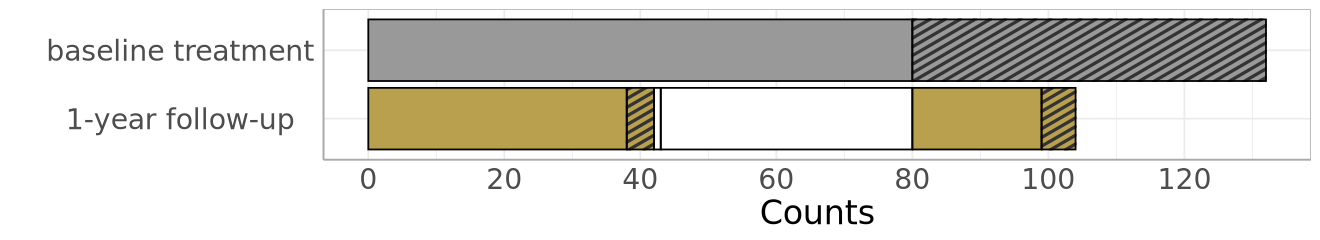

In [23]:
# set a figure size
width = 11
height = 2
options(repr.plot.width=width, repr.plot.height=height)

# plot a figure
p <- ggplot(df_counts, aes(fill=type, x=counts, y=timepoint, pattern=type)) + 
    geom_bar_pattern(stat="identity", colour="black",
            position=position_stack(reverse = TRUE)) +
    scale_pattern_manual(values=c("none", "stripe", "none", "stripe",
                                 "none", "none",
                                 "none", "stripe")) +
    scale_fill_manual(values = c('#999999', '#999999',
                                 '#b9a04f', '#b9a04f', 'white',  'white', 
                                 '#b9a04f', '#b9a04f')) +
    scale_x_continuous(breaks=seq(0, 132, 20)) +
    theme_minimal() +
    theme(axis.text=element_text(size=15),
            axis.title=element_text(size=20, face="plain"), 
            plot.title=element_text(size=25, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 18, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_text(size=17, angle=0, face='plain', hjust=0.5),
            axis.text.y = element_text(size=17, angle=0, face='plain', hjust=0.5),
            axis.title.y = element_text(color='#656565', face='plain'),
            text = element_text(size = 20, face="plain"), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
            panel.border     = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(2, "lines"),
            legend.position="none") +
    labs(y='', x='Counts')

k = 0.3 # a scaling parameter
ggsave(file=file.path('../../results/figures', 'figure1', 'STH_counts.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)
print(p)

## 1D Reported anthihelmintic treatment

#### Transform questionary about prior deworming month into categories: "never" (month = 0), "at least once" (month > 0)

In [25]:
metadata <- sample_data(ps)
# clean a correponding metadata column
metadata$prior_deworming_month <- metadata[['Ifyeswhenwasthelasttimetheygaveyousuchdewormingpill']]
metadata$prior_deworming_month <- gsub('Months', '', metadata$prior_deworming_month)
# replace absent data with zeros
metadata[metadata$prior_deworming_month == ' ', "prior_deworming_month"] <- '0'
metadata$prior_deworming_month <- as.integer(metadata$prior_deworming_month) # transform to numbers
metadata$prior_deworming <- metadata$prior_deworming_month # create a dummy column
# assign the correponding categories
metadata[(metadata$prior_deworming_month == 0), "prior_deworming"] <- 'never' 
metadata[(metadata$prior_deworming_month > 0), "prior_deworming"] <- 'at least once'
# combine deworming information with sampling time
metadata$prior_deworming <- paste(metadata$collection_timepoint, metadata$prior_deworming, sep='_')

#### Get counts for each group

In [26]:
# get counts
df_counts <- data.frame(table(metadata$prior_deworming))
# retrieve a sampling timepoint
df_counts$timepoint <- lapply(df_counts$Var1, function(x){str_split(x, '_')[[1]][1]})
df_counts$timepoint <- factor(unlist(df_counts$timepoint), levels=c('follow-up', 'baseline')) # factorize
levels(df_counts$timepoint) <- c('1-year follow-up', 'Before treatment') # rename factors
# retrieve a prior deworming status
df_counts$treatment <- lapply(df_counts$Var1, function(x){str_split(x, '_')[[1]][2]}) 
df_counts$treatment <- factor(unlist(df_counts$treatment)) # factorize
df_counts

Var1,Freq,timepoint,treatment
<fct>,<int>,<fct>,<fct>
baseline_at least once,83,Before treatment,at least once
baseline_never,49,Before treatment,never
follow-up_at least once,46,1-year follow-up,at least once
follow-up_never,21,1-year follow-up,never


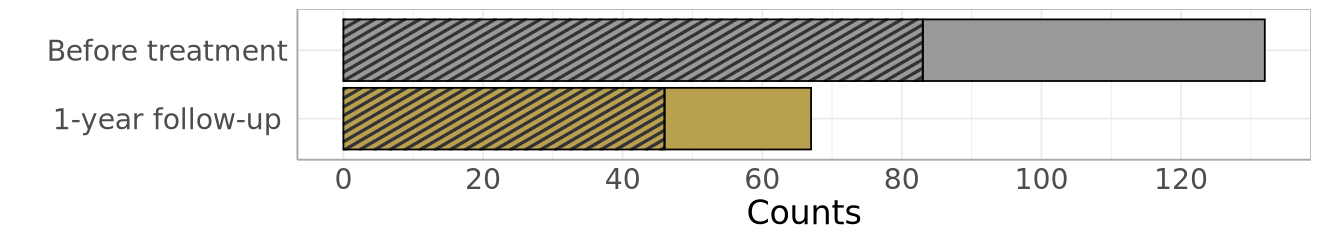

In [28]:
# set a figure size
width = 11
height = 2
options(repr.plot.width=width, repr.plot.height=height)

p <- ggplot(df_counts, aes(fill=timepoint, x=Freq, y=timepoint, pattern=treatment)) + #
    geom_bar_pattern(
             stat="identity", colour="black",
            position=position_stack(reverse = TRUE)) + 
    scale_pattern_manual(values=c("stripe", "none")) +
    scale_fill_manual(values = c('#b9a04f', '#999999')) +
    scale_x_continuous(breaks=seq(0, 132, 20)) +
    theme_minimal() +
    theme(axis.text=element_text(size=15),
            axis.title=element_text(size=20, face="plain"), 
            plot.title=element_text(size=25, face="bold"),
            plot.subtitle=element_text(size=22, face="plain"),
            strip.text = element_text(size = 18, hjust=0, color='#656565'), 
            axis.text.x.bottom = element_text(size=17, angle=0, face='plain', hjust=0.5),
            axis.text.y = element_text(size=17, angle=0, face='plain', hjust=0.5),
            axis.title.y = element_text(color='#656565', face='plain'),
            text = element_text(size = 20, face="plain"), 
            axis.line.y = element_line(color = "darkgrey", linewidth = 0.5), 
            axis.line.x.bottom = element_line(color = "darkgrey", linewidth = 0.5), 
            panel.border     = element_rect(fill = NA, colour = "grey70", linewidth = rel(1)),
            panel.spacing.x = unit(2, "lines"),
            legend.position="none") +
    labs(x='Counts', y='') 

k = 0.3 # a scaling parameter
ggsave(file=file.path('../../results/figures', 'figure1', 'treatment_counts.svg'), plot=p, 
       width=width*k, height=height*k, scaling = k)
print(p)